C:\Users\jorda\AppData\Local\Temp\ipykernel_22552\3360590601.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_individual, _ = curve_fit(decay_model, time_individual, viral_load_individual, p0=[0.1, initial_V0_individual], bounds=(0, [np.inf, np.inf]), maxfev=10000)


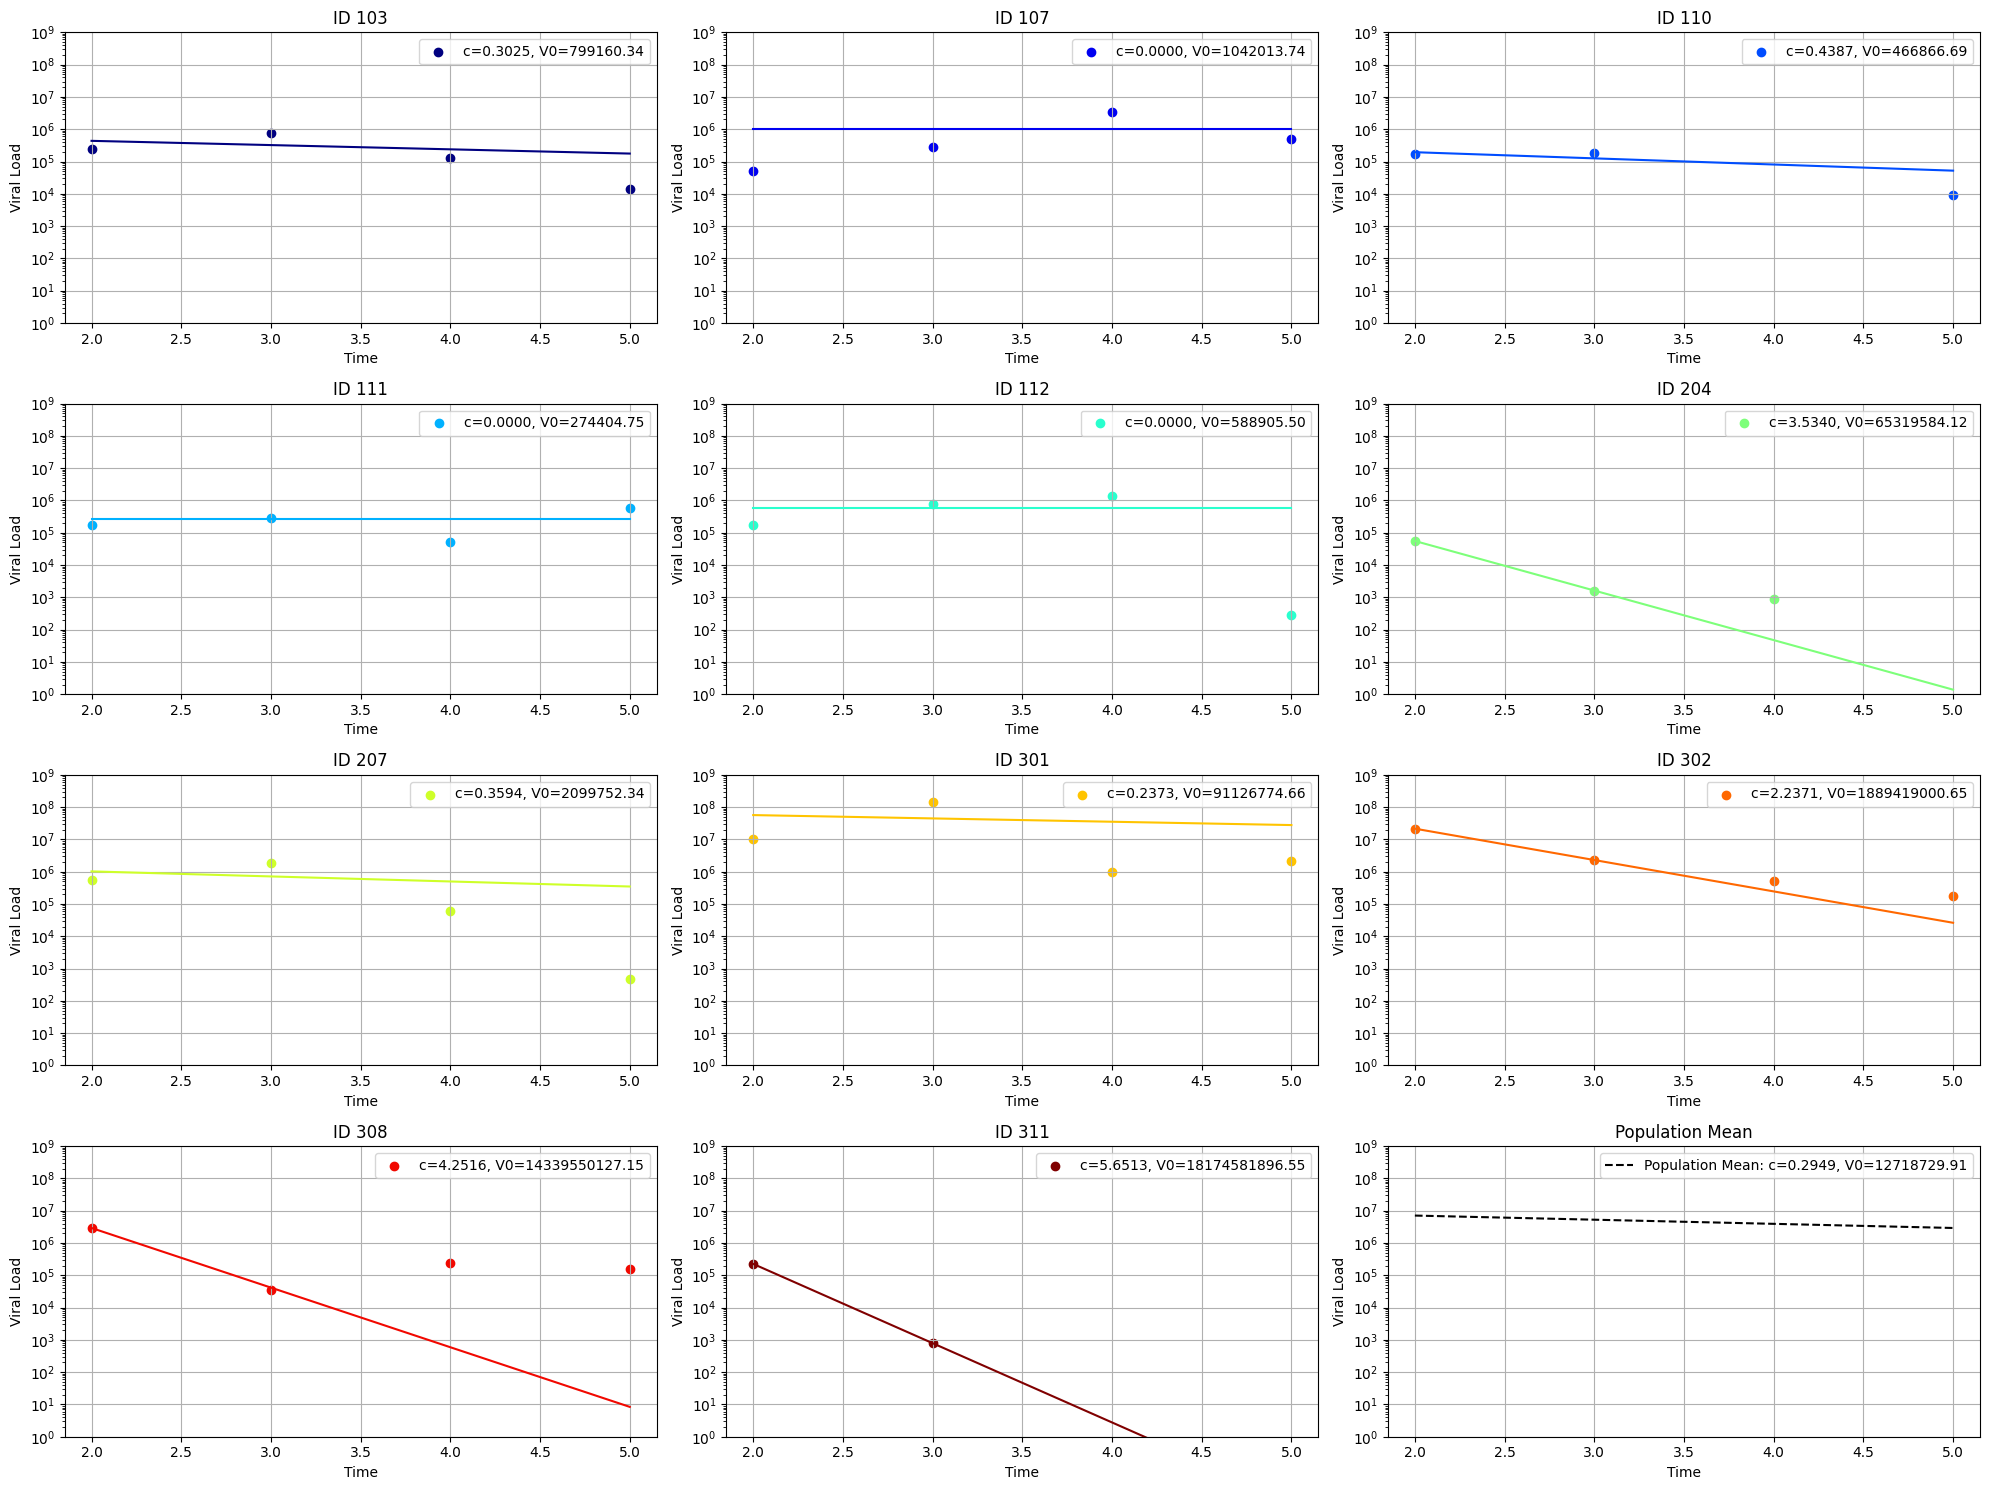

In [14]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

file_path = 'V_Regress.xlsx'
data = pd.read_excel(file_path)
# Filter IDs
ids = [103, 110, 204, 207, 301, 302, 308, 311]
ids = [103, 107, 110, 111, 112, 204, 207, 301, 302, 308, 311]
#ids = [107, 111, 112, 312]
data = data[data['ID'].isin(ids)]

# Define the decay model function
def decay_model(t, c, V0):
    return V0 * np.exp(-c * t)

# Fit the decay model to the population data with an initial guess for V0 as the mean of the first time points
initial_V0 = 36359.29835
time = data['TIME'].values
viral_load = data['Y'].values
popt, pcov = curve_fit(decay_model, time, viral_load, p0=[0.1, initial_V0], bounds=(0, [np.inf, np.inf]), maxfev=10000)
c_population, V0_population = popt

# Fit the decay model to each individual ID
c_values = {}
V0_values = {}
for individual in data['ID'].unique():
    individual_data = data[(data['ID'] == individual) & (data['Y'] > 0)]
    if len(individual_data) > 1:  # Need at least 2 points to fit
        time_individual = individual_data['TIME'].values
        viral_load_individual = individual_data['Y'].values
        initial_V0_individual = individual_data['Y'].iloc[0]
        popt_individual, _ = curve_fit(decay_model, time_individual, viral_load_individual, p0=[0.1, initial_V0_individual], bounds=(0, [np.inf, np.inf]), maxfev=10000)
        c_values[individual] = popt_individual[0]
        V0_values[individual] = popt_individual[1]

# Create subplots for each individual
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
axs = axs.flatten()

colors = plt.cm.jet(np.linspace(0, 1, len(data['ID'].unique())))

for i, (individual, color) in enumerate(zip(data['ID'].unique(), colors)):
    individual_data = data[data['ID'] == individual]
    ax = axs[i]
    ax.scatter(individual_data['TIME'], individual_data['Y'], label=f'ID {individual}', color=color)
    if individual in c_values:
        ax.plot(individual_data['TIME'], decay_model(individual_data['TIME'], c_values[individual], V0_values[individual]), color=color)
    ax.set_title(f'ID {individual}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Viral Load')
    ax.set_ylim(bottom=1, top=1E9)
    ax.set_yscale('log')
    ax.legend([f'c={c_values[individual]:.4f}, V0={V0_values[individual]:.2f}'], loc='best')
    ax.grid(True)

# Plot the mean regression trace on a separate subplot
time_range = np.linspace(data['TIME'].min(), data['TIME'].max(), 100)
axs[-1].plot(time_range, decay_model(time_range, c_population, V0_population), color='black', linestyle='--', label=f'Population Mean: c={c_population:.4f}, V0={V0_population:.2f}')
axs[-1].set_title('Population Mean')
axs[-1].set_xlabel('Time')
axs[-1].set_ylabel('Viral Load')
axs[-1].set_yscale('log')
axs[-1].set_ylim(bottom=1, top=1E9)
axs[-1].legend(loc='best')
axs[-1].grid(True)

plt.tight_layout()
plt.show()

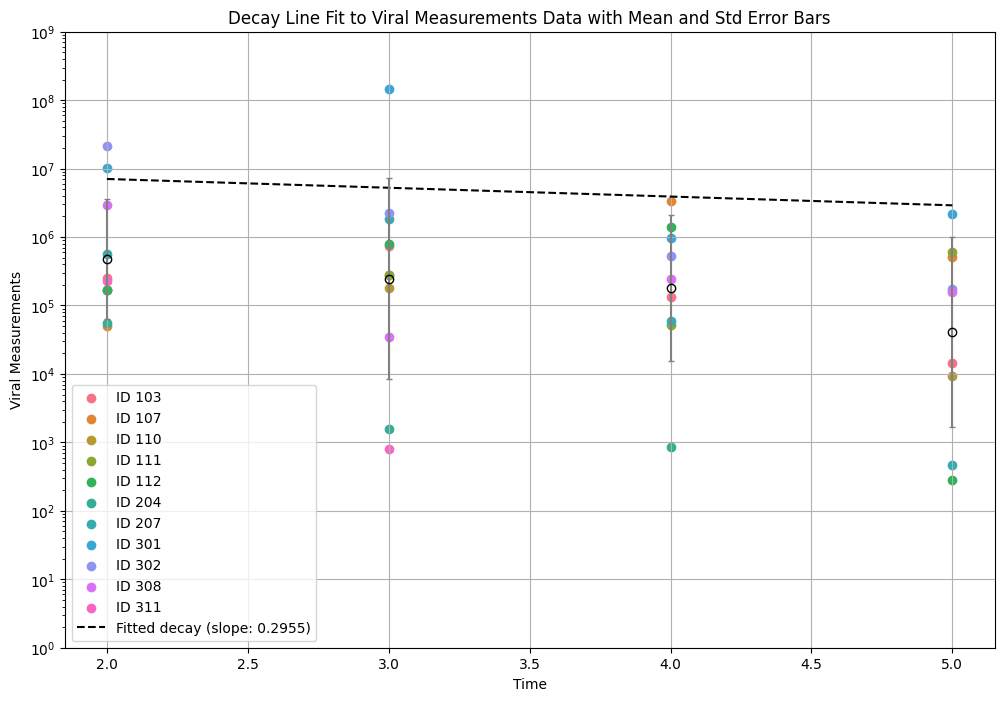

In [11]:
# Filter the data for the specific IDs
ids = [103, 107, 110, 111, 112, 204, 207, 301, 302, 308, 311]
filtered_data = data[data['ID'].isin(ids)]


# Define the decay model function
def decay_model(t, c, V0):
    return V0 * np.exp(-c * t)

# Calculate the mean of the first time points for each ID
initial_V0 = filtered_data.groupby('ID').first()['Y'].mean()

# Prepare the time points and measurements for fitting
time = filtered_data['TIME'].values
viral_load = filtered_data['Y'].values

# Fit the decay model to the data starting from the mean initial condition
popt, pcov = curve_fit(decay_model, time, viral_load, p0=[0.1, initial_V0], bounds=(0, [np.inf, np.inf]), maxfev=10000)
c_population, V0_population = popt

# Generate colors for each ID
unique_ids = filtered_data['ID'].unique()
colors = unique_colors(unique_ids)

# Calculate the mean and standard deviation for each time point
log_viral_load = np.log10(filtered_data['Y'].replace(0, np.nan))
mean_log_viral_load = log_viral_load.groupby(filtered_data['TIME']).mean()
std_log_viral_load = log_viral_load.groupby(filtered_data['TIME']).std()

# Split std into positive and negative parts
mean_values = 10 ** mean_log_viral_load
std_positive_values = 10 ** (mean_log_viral_load + std_log_viral_load) - mean_values
std_negative_values = mean_values - 10 ** (mean_log_viral_load - std_log_viral_load)

# Plot the data and the fitted decay line
plt.figure(figsize=(12, 8))

for unique_id in unique_ids:
    subset = filtered_data[filtered_data['ID'] == unique_id]
    plt.scatter(subset['TIME'], subset['Y'], label=f'ID {unique_id}', color=colors[unique_id])

# Plot the fitted decay line
time_range = np.linspace(filtered_data['TIME'].min(), filtered_data['TIME'].max(), 100)
viral_fit = decay_model(time_range, c_population, V0_population)
plt.plot(time_range, viral_fit, label=f'Fitted decay (slope: {c_population:.4f})', color='black', linestyle='--')

# Plot mean and standard deviation error bars
plt.errorbar(mean_log_viral_load.index, mean_values, yerr=[std_negative_values, std_positive_values], 
             fmt='o', markerfacecolor='none', color='black', ecolor='gray', capsize=2, zorder=10)

plt.xlabel('Time')
plt.ylabel('Viral Measurements')
plt.yscale('log')
plt.ylim(bottom=1, top=1E9)
plt.legend()
plt.title('Decay Line Fit to Viral Measurements Data with Mean and Std Error Bars')
plt.grid(True)
plt.show()